# Exercise 3: Using types - a simple N-body in 80 lines

Julia makes it easy to write your own types, which are similar to structs in C-family languages. Multiple dispatch adds a powerful way to handle tasks like default values or different behaviours really easily.

Here we'll look at how you could construct a simple N-body code. We'll assume everything has mass 1 to keep it simple.

Tasks:
* define an abstract type representing the bodies in the simulation
* define subtypes of this representing two different kinds of bodies in 2D: a moving body and a fixed body
* define a type which holds all the bodies in the simulation
* make a few of these bodies in various positions to start
* write a movement function to move the bodies as necessary
* write a force function to give an inverse square law force between bodies
* write an acceleration function to apply gravity to the bodies
* write a step function to bring it all together (acceleration and movement)

Extras:
* write plot functions for individual points and for the whole system
* plot it and watch the carnage

## Define an abstract type representing the bodies in the simulation

This code block demonstrates how to define an abstract type: a type whose only purpose is to encompass other types.

In [1]:
abstract Body

## Define subtypes of this representing moving and fixed bodies in 2D

This code block demonstrates how to define "concrete types" which actually contain values. We declare two types, MovingBody and FixedBody, and make them subtypes of Body (by writing **`<: Body`**). We also write a function `MovingBody(x,y)` which makes a MovingBody that defaults to zero movement.

In [2]:
type MovingBody <: Body
    x::Float64
    y::Float64
    dx::Float64
    dy::Float64
end
MovingBody(x, y) = MovingBody(x, y, 0, 0)

type FixedBody <: Body
    x::Float64
    y::Float64
end

## Define a type which holds all the bodies in the simulation

This code block demonstrates the syntex to use when specifying the types of arrays. We could have written `Array{Body, 1}` to specify a 1D array containing `Body` types, but `Vector{Body}` is a slightly shorter way of writing the same thing.

In [3]:
type System
    bodies::Vector{Body}
end

## Make a few of these in various positions to start

This code block demonstrates how we can make instances of the body types we just defined. It's nice to put as much of this in a function as possible.

In [4]:
function setup()
    p1 = FixedBody(0,0)
    p2 = MovingBody(1,0) # defaults to no motion ... like writing MovingBody(1,0,0,0)
    p3 = MovingBody(1,1,1,1)
    p4 = MovingBody(0,1,1,-1)
    bodies = [p1, p2, p3, p4]
    
    System(bodies)
end

sys = setup()

System(Body[FixedBody(0.0,0.0),MovingBody(1.0,0.0,0.0,0.0),MovingBody(1.0,1.0,1.0,1.0),MovingBody(0.0,1.0,1.0,-1.0)])

## Write a movement function to move the bodies as necessary

The convention in Julia is to put a ! on the end of the function name if it modifies its arguments. Since we're actually changing the body here (we alter the body's x and y positions), we call the function **`move!`**.

In [5]:
const dt = 0.1  # declare it as const because it's not in a function

function move!(b::MovingBody)
    b.x += b.dx * dt
    b.y += b.dy * dt
    
    b # we return the body here - its coordinates have now been altered
end

move!(b::FixedBody) = b

move! (generic function with 2 methods)

See how we just wrote a second version of **`move!`** but defined it to only be applicable to a FixedBody? Now we can call **`move!`** on either a MovingBody or a FixedBody and know that it will behave appropriately.

## Write a force function to give an inverse square law force between bodies

This code block shows how you can use Unicode characters like ² (type `\^2` and press <kbd>Tab</kbd>) in variable names to make them more compehensible.

In [6]:
function force(b1::Body, b2::Body)
    dx = b2.x - b1.x
    dy = b2.y - b1.y
    d² = dx^2 + dy^2 + 1e-9  # we add a 1e-9 softening term to avoid dividing by zero
    inv_d² = 1 / d²
    Fx = dx * inv_d²
    Fy = dy * inv_d²
    
    Fx, Fy
end

force (generic function with 1 method)

## Write an acceleration function to apply gravity to the bodies

This function needs to include the system (group of bodies) as an argument, because each body is affected by the gravity of all other bodies in the system. Another option would be to make `sys`, the `System`, a global variable. But this option is nicer style and lets us make multiple `System`s if we want.

In [7]:
function accelerate!(sys::System, b::MovingBody)
    d2x = 0.0
    d2y = 0.0
    for other in sys.bodies
        if b !== other
            Fx, Fy = force(b, other)
            d2x += Fx
            d2y += Fy
        end
    end
    b.dx += d2x * dt
    b.dy += d2y * dt
    
    b
end

accelerate!(sys::System, b::FixedBody) = b

accelerate! (generic function with 2 methods)

## Write a step function to bring it all together

By this stage, the step function is really simple to write. We write two versions: one which steps an individual particle, and one which calls the same function but on every particle in a system.

In [8]:
function step!(sys::System, b::Body)
    accelerate!(sys, b)
    move!(b)
end

function step!(sys::System)
    for b in sys.bodies
        step!(sys, b)
    end
end

step! (generic function with 2 methods)

## Extra: plot functions to plot individual points and the system

Since the `plot` and `scatter` (etc) commands from Matplotlib overlay plots by default, we can take advantage of this by writing different `plot` commands for different points. We make fixed things red, moving things black with direction arrows, and then write a third `plot` command to plot everything in the system by just calling `plot` on each individual point.

In [9]:
using PyPlot

function plot(b::FixedBody)
    scatter(b.x, b.y, s=50, color="Red")
end

function plot(b::MovingBody)
    scatter(b.x, b.y, s=50, color="Black")
    arrow(b.x, b.y, b.dx * dt/2, b.dy * dt/2, facecolor="Black")
end

function plot(s::System)
    for b in s.bodies
        plot(b)
    end
    axis("equal")
end

INFO: Loading help data...


plot (generic function with 3 methods)

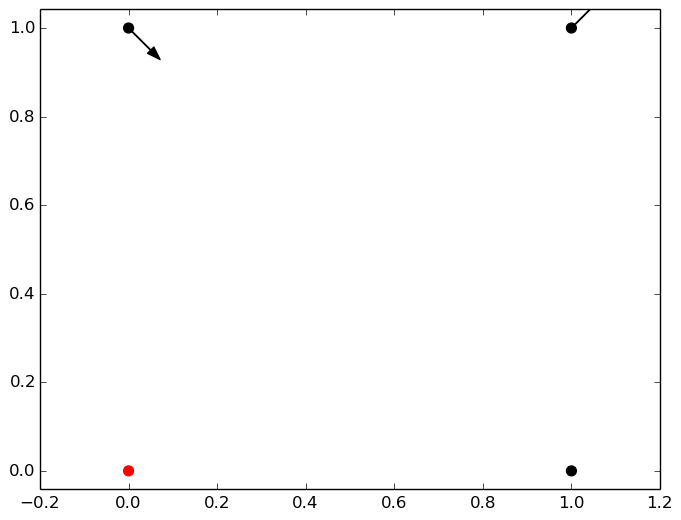

(-0.2,1.2000000000000002,-0.2,1.2000000000000002)

In [11]:
sys = setup()
plot(sys)

## Watch the carnage

Here's what that looks like if we plot the system over 5 time units. By overplotting, we build up a simple trajectory.

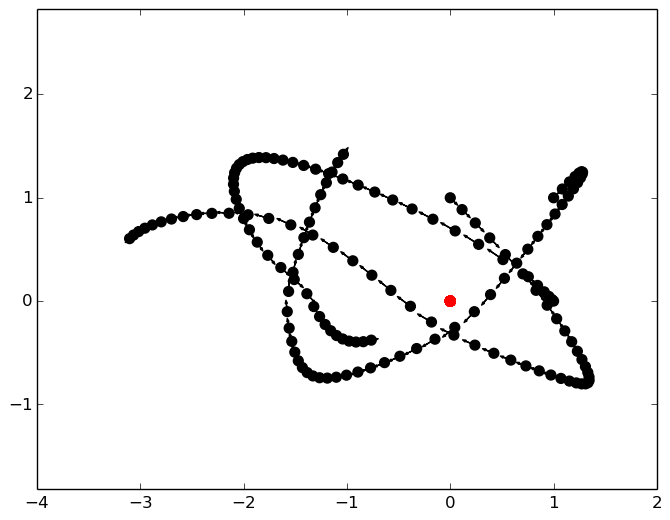

In [12]:
for t = 0:dt:5
    plot(sys)
    step!(sys)
end